<a href="https://colab.research.google.com/github/agvergara/Exploratory_Data_Analysis_Bot/blob/master/cunhaobot_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistics Cunhaobot

First, let's check if all the requirements are installed and, if not, install them (in Google Colab) but if they are installed, import all of them.

In [0]:
pandas_check = !pip show pandas

if not pandas_check:
  !pip install pandas
else:
  import pandas as pd
  
numpy_check = !pip show numpy

if not numpy_check:
  !pip install numpy
else:
  import numpy as np
  
plt_check = !pip show matplotlib

if not plt_check:
  !pip install matplotlib
else:
  import matplotlib.pyplot as plt
  %matplotlib inline

import json
from collections import Counter

Now let's get our data from Google Drive!

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then clean a bit the json file containing all the information.

In [0]:
results = []
path = '/content/drive/My Drive/data_bot/bq-results-20190624-222826-z9jyo1950ix9.json'
# To use it locally
#path = 'bq-results-20190624-222826-z9jyo1950ix9.json'
with open(path, encoding='latin-1') as f:
    for line in f.read().strip().split("\n"):
        results.append(json.loads(line)['textPayload'])


clean_results = []
for result in results:
    if not result.endswith("}"):
        continue
    if not result.startswith("{"):
        result = result[result.index("{"):]
    clean_results.append(result)


#slow and dangerous
results_dicts = [eval(result) for result in clean_results]

And trim a little more the file to save the things we want to get the statistics.

First, we get the 'query_inline_results', those results contain all the information we want: Username (or first name), query type (if the query is long, short, audio...), user_id (Telegram user id) and the query data the user used or submited; if something is not found is replaced by "EMPTY" (or "Maybe" (2) in the case if the user is a bot or not... You can't be 100% sure).

Lastly, create a dictionary with all this information to get Pandas DataFrame working.

In [0]:
inline_results = [msg for msg in results_dicts if 'chosen_inline_result' in msg.keys()]
usernames = []
list_queries = []
for idx in range(len(inline_results)):
    try:
        user = inline_results[idx]['chosen_inline_result']['from']['username']
    except KeyError:
        user = inline_results[idx]['chosen_inline_result']['from']['first_name']
    user_id = inline_results[idx]['chosen_inline_result']['from']['id']
    try:
        is_bot = inline_results[idx]['chosen_inline_result']['from']['is_bot']
    except KeyError:
        is_bot = "Maybe"
    try:
        query_type = inline_results[idx]['chosen_inline_result']['query']
    except KeyError:
        query_type = "EMPTY"
    try:
        query_data = inline_results[idx]['chosen_inline_result']['result_id']
    except KeyError:
        query_data = "EMPTY"
    list_queries.append((user_id, user, is_bot, query_type, query_data))
    if (user not in usernames):
        usernames.append(user)

query_dict = {}
queries = []
lines = []
user_checked = []
uses = [user[1] for user in list_queries]
id_user = 0
for tuple_query in list_queries:
    current_user_id = tuple_query[0]
    current_user = tuple_query[1]
    current_user_is_bot = tuple_query[2]
    if current_user not in user_checked:
        n_uses = len([idx for idx in range(len(uses)) if uses[idx] == current_user])
        query_types = [query[3] for query in list_queries if current_user == query[1]]
        queries_data = [line[4] for line in list_queries if current_user == line[1]]
        user_checked.append(current_user)
        query_dict[id_user] = {'user_id': current_user_id, 'user': current_user,
                               'is_bot': current_user_is_bot, 'query_type': query_types,
                               'query_data': queries_data, 'num_uses': n_uses}
        id_user += 1


Now the F-U-N begins, let's get the DataFrame and study the logs!

In [28]:
dataframe_logs = pd.DataFrame(query_dict).transpose()
num_observations = len(dataframe_logs.index)
num_features = len(dataframe_logs.columns)

print("There are: {} observations and {} features right now".format(num_observations, num_features))

There are: 128 observations and 6 features right now


### Bot Usage
So we're here now, huh? Let's get some sweet, sweet stats, but first, let me define some functions and some colors to make it spicy

In [0]:
def extract_query_type(data):
    query_uses = ['audio', 'sonido', 'sound', 'mp3', 'ogg',
            'frase', 'long', 'larga', 'largo',
            'ayuda', 'help']
    dict_query_type = {}
    id_query = 0
    for query_type_list in data["query_type"]:
        for query_type in query_type_list:
            if ((query_type == 'EMPTY') or (query_type == '')):
                query_type = "corta"
            else:
                try:
                    aux = int(query_type[0])
                    if (type(aux) == int):
                        query_type = "corta"
                except ValueError:
                    try:
                        aux = query_type.split(" ")[0]
                        if (aux in query_uses):
                            query_type = aux
                        else:
                            query_type = "mal"
                    except IndexError:
                        pass
                except IndexError:
                    pass
            dict_query_type[id_query] = {'query_type': query_type}
            id_query += 1
    return dict_query_type

def print_bars_graph(dataframe, colors, xlabel, ylabel, title):
    _, ax = plt.subplots()
    data = Counter(dataframe)
    print(data)
    height = [val for key, val in data.items()]
    x = np.arange(len(data))
    ax.bar(x, height, edgecolor='black', linewidth=1, color=colors)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(x, (data.keys()))
    plt.grid()
    plt.title(title)
    plt.show()

def print_user_stats(user_to_search):
    user_stats = dataframe_logs.loc[dataframe_logs['user'] == user_to_search]
    data_use_user = pd.DataFrame.from_dict(extract_query_type(user_stats)).transpose()
    title = "Number of uses of this bot by user: " + user_to_search
    xlabel = "Type of uses"
    ylabel = "Number of uses"
    print_bars_graph(data_use_user["query_type"], colors, xlabel, ylabel, title)
    print("This user used this bot {} times in total.".format(len(data_use_user)))

def extract_words_query(data):
    words = []
    queries = [query for query in data['query_type']]
    for word_list in queries:
        for word in word_list:
            try:
                aux_word = word.split(" ")[1]
                words.append(aux_word)
            except IndexError:
                pass
                #words.append(word)
    return words

colors = ['crimson', 'chartreuse', 'aqua', 'skyblue', 'orange',
          'salmon', 'royalblue', 'olive', 'navy', 'gray']

#### General usage

##### Bots using this bot

Counter({'Maybe': 82, False: 46})


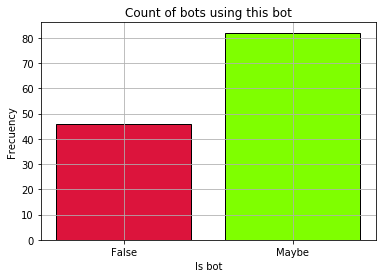

In [33]:
xlabel = "Is bot"
ylabel = "Frecuency"
title = "Count of bots using this bot"
print_bars_graph(dataframe_logs["is_bot"], colors, xlabel, ylabel, title)


#### General usage of the bot

Counter({'corta': 1196, 'audio': 448, 'frase': 434, 'larga': 76, 'long': 68, 'mal': 58, 'largo': 22, 'help': 6, 'sonido': 4, 'ayuda': 4})


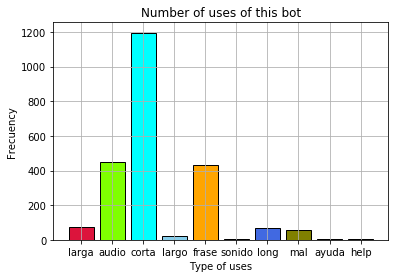

This bot has been used 2316 times in total.


In [34]:
data_use = pd.DataFrame.from_dict(extract_query_type(dataframe_logs)).transpose()
print_bars_graph(data_use["query_type"], colors, "Type of uses", "Frecuency", "Number of uses of this bot")
print("This bot has been used {} times in total.".format(len(data_use)))

#### Wordcloud!

#### User stats for this bot

Counter({'frase': 6, 'corta': 2})


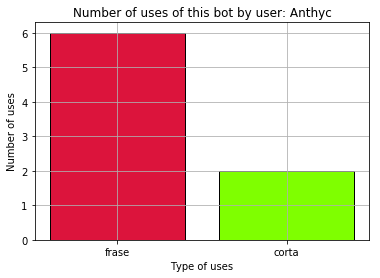

This user used this bot 8 times in total.

 Here it comes the wordcloud!



In [37]:
user_to_search = 'Anthyc'
print_user_stats(user_to_search)
print("\n Here it comes the wordcloud!\n")

#### Query stats 
(Change _verbose_ to get the user stats also)

In [36]:
query_to_search = "audio"
query_stats = []
user_checked = []
for row in dataframe_logs.iterrows():
    for query in row[1]['query_type']:
        if ((query_to_search in query) and (row[1]['user'] not in user_checked)):
            query_stats.append(row[1])
            user_checked.append(row[1]['user'])

verbose = False
print("Searching for query: " + query_to_search)
print("Number of times query is found: {}".format(len(query_stats)))
for query in query_stats:
    print("Query found by user: " + query['user'])
    if (verbose):
        print_user_stats(query['user'])
        print("\n")


Searching for query: audio
Number of times query is found: 21
Query found by user: jenarvaezg
Query found by user: atcolombini
Query found by user: RPard
Query found by user: p4k0p4
Query found by user: DonM21
Query found by user: niptim
Query found by user: Hopper
Query found by user: Alfonsitor
Query found by user: Nokichan
Query found by user: javierlunamolina
Query found by user: Alfree94
Query found by user: Angel9z
Query found by user: Vinegar321
Query found by user: Kiriqui
Query found by user: Dani
Query found by user: annajor
Query found by user: Alrik93
Query found by user: mr_badgr
Query found by user: desgat
Query found by user: MaximRS
Query found by user: Joel
